In [2]:
# MUST run for notebooks, running the scripts is fine
import sys
import os
import torch
sys.path.append(os.path.abspath(".."))  # adding the root directory 'thesis/'

In [3]:
# TEMPORARY DEV SPACE FOR analysis.py

# load the result grid and analyze different (practical) aspects of the
# training itself and the evolution of metrics

import matplotlib.pyplot as plt
import numpy as np
import ray.tune as tune
from analysis.helpers import *
from main.train_cluster import get_ray_trainer
from models.modules.rnn_module import * 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os

class Analyzer():
    def __init__(self, experiment_path, train_data_path):
        """Load the best model of a tuning session and analyze its latents
        
        Args:
            checkpoint_dir (str): path to the train session full ~/ray_results/TorchTrainer[...]
            train_data_path (str): path to the h5py file generated by the TaskDataModule
            lightning_module (pl.LightningModule): the model used for training this tuning run
        """
        self.experiment_path = experiment_path
        self.train_data_path = train_data_path 
        self.best_model=None   # model.pt
        self.best_model_metadata = None   # format??
        self.result_grid = None
        (   self.train_input,
            self.train_target,
            self.train_init,
            self.val_input,
            self.val_target, 
            self.val_init
        ) = self.load_train_dataset()
        
    def load_result_grid(self):
        # get the objective function that returns the TorchTrainer
        trainable = get_ray_trainer()
        # load the result grid from the TorchTrainer experiment
        restored_tuner = tune.Tuner.restore(self.experiment_path, trainable=trainable)
        self.result_grid = restored_tuner.get_results()
        return self.result_grid
        
    
    def load_best_model(self, metric='ptl/val_accuracy', mode='max'):
        """Load the best model and return its lightning module 
            metric (str): The key for checkpoints to order on
            mode (str): One of [“min”, “max”]
            
            Call this function again to change the metrics for best model
        """
        if self.result_grid == None:
            self.load_result_grid()
        best_result = self.result_grid.get_best_result()        
        self.best_model = GeneralModel(best_result.config['train_loop_config'])
        

    def inference(self, input=None, initial_states=None, val=True):
        """Run inference, mimic the original torch interface.
        Return (readout, trajectories) for the given input and inits and
        manually put this into the plotting/analysis functions
        """
        if self.best_model == None:
            self.load_best_model()
        # disable batch normalization, dropout, randomness
        self.best_model.model.eval() # TODO: you only have to do this once
        if input is None:
            input = self.val_input if val else self.train_input
        if initial_states is None:
            initial_states = self.val_init if val else self.train_init
            
        # run inference
        readout, trajs = self.best_model.model(input, return_latents=True, initial_states=initial_states)
            
        return readout, trajs


    def plot_latent_space(self, trajs, input=None, plot_field=True, pca=False, val=True,
                          latent_range=[[-1,1],[-1,1]], num_points=10, cmap=plt.cm.Reds, **kwargs):
        """Plot the trajectories and/or vector field of the latent
        variables of a trained model, given trajectories from model()
        """
        trajs = trajs.detach().numpy() 
        trials, timesteps, dim = trajs.shape
        colors = plt.cm.viridis(np.linspace(0, 1, trials))  # Generate different colors for each trial
        
        if not input:
            input = self.val_input if val else self.train_input

        fig = plt.figure(figsize=(10, 6))

        if dim == 2:
            ax = fig.add_subplot(111)
            for trial in range(trials):
                ax.plot(trajs[trial, :, 0], trajs[trial, :, 1], color=colors[trial])
            ax.set_xlabel('latent 1')
            ax.set_ylabel('latent 2')
        elif dim == 3:
            ax = fig.add_subplot(111, projection='3d')
            for trial in range(trials):
                ax.plot(trajs[trial, :, 0], trajs[trial, :, 1], trajs[trial, :, 2], color=colors[trial])
            ax.set_xlabel('latent 1')
            ax.set_ylabel('latent 2')
            ax.set_zlabel('latent 3')
        else:
            # do dimensionality reduction
            to_reduce = trajs.reshape(-1, dim)
            if PCA:
                reduced = PCA(n_components=2).fit_transform(to_reduce)
            else:
                reduces = TSNE(n_components=2).fit_transform(to_reduce)
            # reshape back to plot with trials, timesteps
            reduced = reduced.reshape(trials, timesteps, 2)
            ax = fig.add_subplot(111)
            for trial in range(trials):
                ax.plot(trajs[trial, :, 0], trajs[trial, :, 1], color=colors[trial])
            ax.set_xlabel('reduced latent 1')
            ax.set_ylabel('reduced latent 2')
        
        # TODO: implement pca/tsne
        
        if plot_field:
            if dim==2:
                U,V,normalized_cmap=self.get_field_data(input, latent_range, num_points)
                colors_map = cmap(normalized_cmap.flatten())
                ax.quiver(*np.meshgrid(latent_range[0], latent_range[1], indexing='ij'), U, V, color=colors_map)
            else:
                U,V,W,normalized_cmap=self.get_field_data(input, latent_range, num_points)
                colors_map = cmap(normalized_cmap.flatten())
                ax = fig.add_subplot(111, projection='3d')
                ax.quiver(*np.meshgrid(latent_range[0], latent_range[1], latent_range[2], indexing='ij'), U, V, W, color=colors_map)
            
        fig.tight_layout()
        plt.show() 
        
        
    def get_field_data(self, input, latent_range, num_points):
        """Return the values for the vectors in the vecgtor field
        created by some model
        input: input dataset to the model during training, NOT the init_states
        latent_range: list of the axis limits for every dimension
                       set it after visualizing only the trajs first
        """
        
        dim = len(latent_range)
        
        # Calculate velocities over a grid using a double for loop implementation
        x = np.linspace(latent_range[0][0], latent_range[0][1], num_points)
        y = np.linspace(latent_range[1][0], latent_range[1][1], num_points)
        if len(latent_range) == 3:
            z = np.linspace(latent_range[2][0], latent_range[2][1], num_points)
            
        if dim == 2:
            U = np.zeros([num_points, num_points])
            V = np.zeros([num_points, num_points])
        else:
            U = np.zeros([num_points, num_points, num_points])
            V = np.zeros([num_points, num_points, num_points])
            W = np.zeros([num_points, num_points, num_points])
            
        for i in range(num_points):
            for j in range(num_points):
                state = torch.tensor([[x[i], y[j]]], dtype=torch.float)
                if dim == 2:
                    U[i, j], V[i, j] = (self.best_model.model(input, state) - state).detach().numpy().flatten()
                else:
                    for k in range(num_points):
                        state = torch.tensor([[x[i], y[j], z[k]]], dtype=torch.float)
                        # removed a 0.1 constant from here
                        U[i, j, k], V[i, j, k], W[i, j, k] = (self.best_model.model(input, state) - state).detach().numpy().flatten()
        
        # Create a colormap based on the normalized magnitude
        if dim == 2:
            magnitude = np.sqrt(U**2 + V**2)
        else:
            magnitude = np.sqrt(U**2 + V**2 + W**2)
        normalized_cmap = ((magnitude - np.min(magnitude)) / (np.max(magnitude) - np.min(magnitude))).flatten()

        if dim==2:
            return U, V, normalized_cmap
        else:
            return U, V, W, normalized_cmap
        
                
    def plot_targets(self, readout, inputs=None, targets=None, phase_index=None, val=True):
        """Plot the inputs and targets vs readout along the experiment
        visualization for each task, given readout from model()"""
        
        # TODO: generalize, this is labeled only for the CDM task
        
        if not inputs:
            inputs = self.val_input if val else self.train_input
        if not targets:
            targets = self.val_target if val else self.train_target
            
        # NOTE: is this even necessary?
        inputs = inputs.squeeze().numpy() 
        targets = targets.squeeze().numpy()
        readout = readout.squeeze().numpy()
        
        # plot the inputs and targets
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].plot(inputs, label=['Channel 0', 'Channel 1', 'Context 0', 'Context 1'])
        ax[0].set_xlim(0, len(inputs))
        ax[0].legend()
        ax[1].plot(targets, color='k', label='targets')
        ax[1].plot(readout, color='r', label='readout')  # BUG: maybe this sould NOT be the readout??
        
        # plot vertical dotted lines at x values of phase_index
        if phase_index:
            for key, val in phase_index.items():
                ax[0].axvline(x=val, color='k', linestyle='--')
                ax[1].axvline(x=val, color='k', linestyle='--')
            
        # add labels
        ax[0].set_xlabel("Binned timesteps (bin_size = {})".format(self.bin_size))
        ax[0].set_ylabel("Input amplitude")
        ax[1].set_xlabel("Binned timesteps (bin_size = {})".format(self.bin_size))
        ax[1].set_ylabel("Target vs Predictions")
        
        fig.tight_layout()
        plt.show() 
        
        
    def load_train_dataset(self):
        """Load the tensors used for training from the saved h5py file"""
        with h5py.File((self.train_data_path), 'r') as f:
                train_inputs = torch.tensor(f['train_inputs'][:])
                train_targets = torch.tensor(f['train_targets'][:])
                train_init_states = torch.tensor(f['train_init_states'][:])
                val_inputs = torch.tensor(f['val_inputs'][:])
                val_targets = torch.tensor(f['val_targets'][:])
                val_init_states = torch.tensor(f['val_init_states'][:])
                train_mask = torch.tensor(f['train_mask'][:])
                val_mask = torch.tensor(f['val_mask'][:])

        return train_inputs, train_targets, train_init_states,val_inputs, val_targets, val_init_states


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import ray.tune as tune
from analysis.helpers import *
from main.train_cluster import get_ray_trainer
# from analysis.analysis import Analyzer
from models.modules.rnn_module import *

# IMPORTANT: give the FULL path to experiment/data files

experiment_path = '/Users/alejandraduran/Documents/THESIS/thesis/synthetic_datasets/local_exp_results/TorchTrainer_2025-02-07_04-03-19'
train_data_path = '/Users/alejandraduran/Documents/THESIS/thesis/synthetic_datasets/local_data/none_5_n_trials2000_bin_size10_noise0.0_n_timesteps3350_ (4).h5'

analyzer = Analyzer(experiment_path, train_data_path)

2025-03-06 08:48:23,738	WARNING tuner_internal.py:270 -- The Tune experiment will restore using the original run's `RunConfig`. If you made any changes to the `RunConfig` within the Trainer you passed into `Tuner.restore`, they will be ignored in the resumed run.


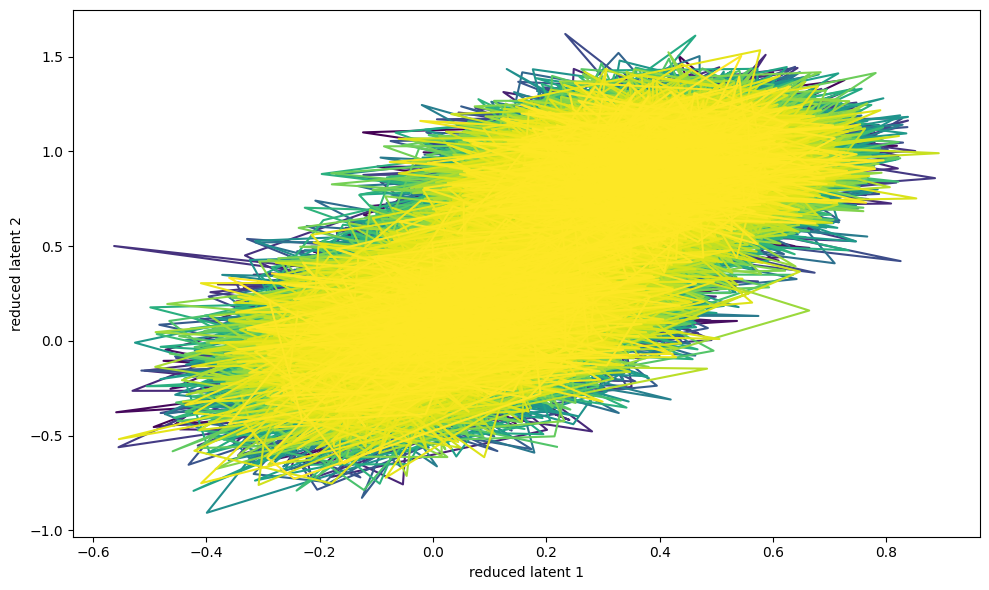

In [6]:
# this loads self.result_grid
result_grid = analyzer.load_result_grid()

best_model = analyzer.load_best_model()  # by accuracy default

readout, trajs = analyzer.inference(val=True)  # without passing in input should use the val input

analyzer.plot_latent_space(trajs, plot_field=False, latent_range=[[-1,1],[-1,1]], num_points=10)

# analyzer.plot_targets(readout)

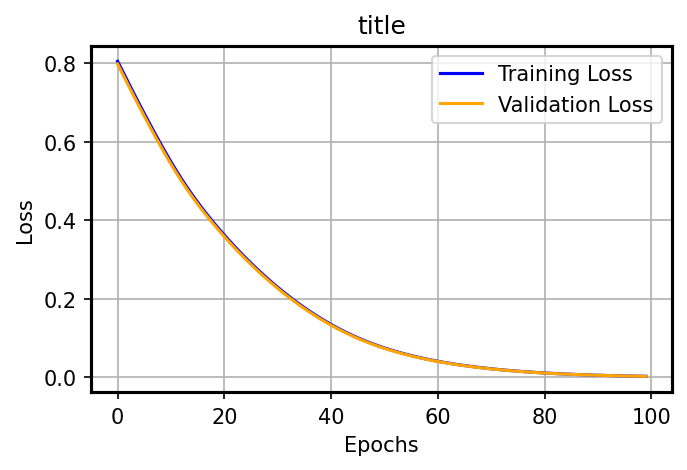

: 

In [8]:
from ray.train import Result
from matplotlib import pyplot as plt

result_path = '/scratch/gpfs/ad2002/task_training/ray_results/TorchTrainer_2025-02-07_04-03-19/TorchTrainer_62632_00004_4_lr=0.0010,noise_std=0.0000,weight_decay=0.0000_2025-02-07_04-03-23'

restored_result = Result.from_path(result_path)

# Plotting the training and validation loss
plt.figure(figsize=(5, 3), dpi=150)  # Set the figure size and high resolution
plt.plot(restored_result.metrics_dataframe['ptl/train_loss'], label='Training Loss', color='blue')
plt.plot(restored_result.metrics_dataframe['ptl/val_loss'], label='Validation Loss', color='orange')

# Adding title and labels with LaTeX-style font
plt.title('title')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Adding a legend
plt.legend()

# Adding grid for better readability
plt.grid(True)

# Adding a crisp frame
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)

# Display the plot
plt.show()

# accuracy is ~1 for frRNN from (literally) the very start, IG it matches Valente et al